[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/devdastl/EVA-8_Capstone_Assignment/blob/main/Part2-Inpainting_implementation/Attempt3_Success.ipynb)

In [1]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from PIL import Image
from diffusers import AutoencoderKL, DDIMScheduler, DiffusionPipeline, PNDMScheduler, UNet2DConditionModel, DPMSolverMultistepScheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


/workspace/capstone_assignment/Part2-inpainting/inpaint_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="vae")
vae.config

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 256),
            ('scaling_factor', 0.18215),
            ('_class_name', 'AutoencoderKL'),
            ('_diffusers_version', '0.6.0.dev0'),
            ('_name_or_path', 'runwayml/stable-diffusion-inpainting')])

In [3]:

tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="unet")
scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="scheduler")
#scheduler = PNDMScheduler.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="scheduler")
feature_extractor = CLIPFeatureExtractor.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="feature_extractor")
safety_checker = StableDiffusionSafetyChecker.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="safety_checker")


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/workspace/capstone_assignment/Part2-inpainting/inpaint_env/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [4]:
device = "cuda"
vae.to(device)
text_encoder.to(device)
unet.to(device)
#feature_extractor.to(device)
safety_checker.to(device)

StableDiffusionSafetyChecker(
  (vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickG

In [5]:
batch_size = 1
num_inference_steps=50
generator=None
strength=0.8
prompt='dummy prompt'
guidance_scale=7.5
eta=0.0

## Utility functions

In [6]:
def preprocess_image_inputs(image, mask, height, width):
    #preprocess PIL image
    image = image.resize((width, height), resample=PIL.Image.LANCZOS)
    image = np.array(image.convert("RGB"))[None, :]
    image = image.transpose(0,3,1,2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    #preprocess PIL mask
    mask = mask.resize((width, height), resample=PIL.Image.LANCZOS)
    mask = np.array(mask.convert("L"))[None, None, :]
    mask = mask.astype(np.float32) / 255.0

    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    #prepare masked image
    masked_image = image * (mask < 0.5)

    return mask, masked_image, image

In [7]:
def prompt_encoding(prompt, guidance_scale, device):
    text_inputs = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_ids = text_inputs.input_ids
    with torch.no_grad():
        prompt_embeds = text_encoder(text_input_ids.to(device))[0]

    do_classifier_free_guidance = guidance_scale > 1.0

    if do_classifier_free_guidance:
        max_length = text_input_ids.shape[-1]
        uncond_input = tokenizer([""]*batch_size, padding='max_length', max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            uncond_embeds = text_encoder(uncond_input.input_ids.to(device))[0]

        prompt_embeds = torch.concat([uncond_embeds, prompt_embeds])

    return prompt_embeds


In [8]:
# prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
# eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.

def prepare_extra_step_kwargs(generator, eta):

        accepts_eta = "eta" in set(inspect.signature(scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

In [25]:
#function to decode latents into images
def decode_latents(latents):
    with torch.no_grad():
        latents = 1 / vae.config.scaling_factor * latents
        image = vae.decode(latents, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().squeeze(dim=0).numpy()
        return image

In [10]:
#function to generate input latents for UNET
def prepare_input_latents(batch_size, height, width, device, generator, image, dtype, timestep=None):

    image = image.to(device, dtype=dtype)
    with torch.no_grad():
        image_latents = vae.encode(image).latent_dist.sample(generator=generator)
        image_latents = vae.config.scaling_factor * image_latents

    noise = torch.randn(image_latents.shape).to(device=device, dtype=dtype)

    latents = scheduler.add_noise(image_latents, noise, timestep)
    latents = latents * scheduler.init_noise_sigma
    return latents


In [11]:
# function to generate latents out of mask
def prepare_mask_latents(mask, masked_image, batch_size, height, width, dtype, device, generator, guidance_scale):

    vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1 )
    mask = torch.nn.functional.interpolate(
            mask, size=(height // vae_scale_factor, width // vae_scale_factor)
        ).to(device, dtype)
    masked_image = masked_image.to(device, dtype)

    with torch.no_grad():
        masked_image_latents = vae.encode(masked_image).latent_dist.sample(generator=generator)
    masked_image_latents = vae.config.scaling_factor * masked_image_latents

    do_classifier_free_guidance = guidance_scale > 1.0

    mask = torch.cat([mask] * 2) if do_classifier_free_guidance else mask
    masked_image_latents = (
        torch.cat([masked_image_latents] * 2) if do_classifier_free_guidance else masked_image_latents
    )

    masked_image_latents = masked_image_latents.to(device=device, dtype=dtype)
    return mask, masked_image_latents

In [12]:
def get_timesteps(num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = scheduler.timesteps[t_start * scheduler.order :]

        return timesteps, num_inference_steps - t_start

## Main implementation

In [73]:
image_path = "init_image.png"
mask_path = "mask_image.png"
prompt = "a person sitting on the bench with a black hat on his head"

generator = torch.manual_seed(10201)

In [74]:
batch_size = 1
num_inference_steps=50
generator=None
strength=0.8
guidance_scale=7.5
eta=0.0

In [75]:
prompt_embeds = prompt_encoding(prompt=prompt, guidance_scale=guidance_scale, device=device)


In [76]:
scheduler.set_timesteps(num_inference_steps, device=device)
timesteps, num_inference_steps = get_timesteps(
            num_inference_steps=num_inference_steps, strength=strength, device=device
        )

In [77]:
# at which timestep to set the initial noise (n.b. 50% if strength is 0.5)
latent_timestep = timesteps[:1].repeat(batch_size * 1)
# create a boolean to check if the strength is set to 1. if so then initialise the latents with pure noise
is_strength_max = strength == 1.0

In [78]:
un_image = Image.open(image_path)
un_mask = Image.open(mask_path)

mask, masked_image, init_image = preprocess_image_inputs(un_image, un_mask, height=512, width=512)

In [79]:
mask.shape, masked_image.shape, init_image.shape

(torch.Size([1, 1, 512, 512]),
 torch.Size([1, 3, 512, 512]),
 torch.Size([1, 3, 512, 512]))

In [80]:
latents = prepare_input_latents(batch_size=batch_size, height=512, width=512, device=device, generator=generator, image=init_image, timestep=latent_timestep, dtype=prompt_embeds.dtype)
mask, masked_image_latents = prepare_mask_latents(mask=mask, masked_image=masked_image, batch_size=batch_size, height=512, width=512, device=device, generator=generator, guidance_scale=guidance_scale, dtype=prompt_embeds.dtype)

latents.shape, mask.shape, masked_image_latents.shape

(torch.Size([1, 4, 64, 64]),
 torch.Size([2, 1, 64, 64]),
 torch.Size([2, 4, 64, 64]))

In [81]:
extra_step_kwargs = prepare_extra_step_kwargs(generator, eta)
do_classifier_free_guidance = guidance_scale > 1.0
callback = None

In [82]:
num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order

for i, t in tqdm(enumerate(timesteps)):
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    latent_model_input = torch.cat([latent_model_input, mask, masked_image_latents], dim=1)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=prompt_embeds, return_dict=False)[0]

    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)  

    latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

    if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % scheduler.order == 0):
        # if callback is not None and i % callback_steps == 0:
        #     callback(i, t, latents)
        pass

image = decode_latents(latents=latents)


56it [00:13,  4.01it/s]


In [83]:
type(image)

numpy.ndarray

In [84]:
print(image)

[[[0.72659254 0.7935238  0.82021475]
  [0.7333159  0.7971366  0.84361017]
  [0.73668253 0.81503946 0.86682343]
  ...
  [0.8527346  0.89465183 0.9358125 ]
  [0.84637535 0.8918149  0.9434699 ]
  [0.85703385 0.898138   0.9284452 ]]

 [[0.7242975  0.7961314  0.82857186]
  [0.72893786 0.8037908  0.85260314]
  [0.73835665 0.81857777 0.86271703]
  ...
  [0.8534777  0.8967489  0.9421886 ]
  [0.85461926 0.89111376 0.94643664]
  [0.8613831  0.8980751  0.9536502 ]]

 [[0.73560584 0.8159076  0.85646635]
  [0.7191996  0.7944521  0.844571  ]
  [0.7115885  0.7925038  0.8325758 ]
  ...
  [0.8567331  0.8940699  0.9384805 ]
  [0.8529676  0.89759266 0.9360596 ]
  [0.85868996 0.8959692  0.94341964]]

 ...

 [[0.3840713  0.39247096 0.32668892]
  [0.43868014 0.42267603 0.37362418]
  [0.6278104  0.6494412  0.57379586]
  ...
  [0.4282462  0.45136452 0.3726876 ]
  [0.4689825  0.45928085 0.38631618]
  [0.62635386 0.6374099  0.55048877]]

 [[0.4344082  0.42681342 0.3521912 ]
  [0.41146803 0.3992257  0.3532458 ]


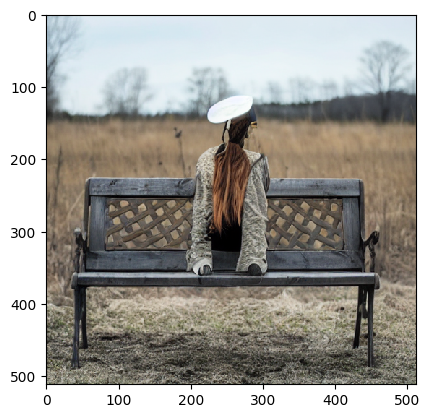

In [85]:
from matplotlib import pyplot as plt

plt.imshow(image, interpolation='nearest')
plt.show()